In [2]:
import numpy as np

import astropy.units as u  
import astropy.constants as c
from astropy.coordinates import SkyCoord, Galactic, CartesianRepresentation

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib 

from scipy.interpolate import interp1d


from astropy.io import fits
from astropy.table import Table, join

bayestar_path = '/uufs/astro.utah.edu/common/home/u1371365/dustmaps_data/bayestar/bayestar2019.h5'
from dustmaps.bayestar import BayestarQuery

### NEW 03-20: implement the 10pc resolution Vergely map into dustmaps ###
from dustmaps.vergely2022 import Vergely2022Query

In [3]:
tabfile = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits'
stars = Table.read(tabfile, hdu = 1)

(-50000.0, 50000.0)

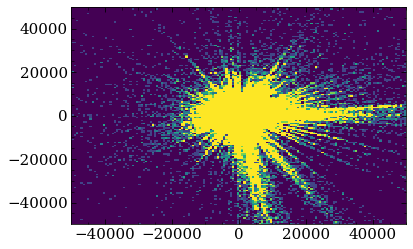

In [4]:
distance = 1000 / stars['GAIAEDR3_PARALLAX'] 
distance[distance < 0] = np.nan
star_coords = SkyCoord(l = stars['GLON'] * u.deg, b = stars['GLAT'] * u.deg, distance = distance*u.pc, frame = 'galactic')
star_coords.representation_type = 'cartesian'

fig, ax = plt.subplots()
# ax.scatter(star_coords.u, star_coords.v)
norm = matplotlib.colors.Normalize(0, 5)
ax.hist2d(star_coords.u.value, star_coords.v.value, range = ((-1e5, 1e5), (-1e5, 1e5)), bins = 300, norm = norm)
ax.set_xlim(-5e4, 5e4)
ax.set_ylim(-5e4, 5e4)
# plt.show()

In [5]:
lambda0 = 15272.42

def get_wavs(hdulist = None, rv = 0):
    if hdulist is None:
        CRVAL1 = 4.179
        CDELT1 = 6e-06
        LEN = 8575
    else:
        header = hdulist[1].header
        CRVAL1 = header['CRVAL1']
        CDELT1 = header['CDELT1']
        LEN = header['NAXIS1']
        
    wavs = np.power(10, CRVAL1 + CDELT1 * np.arange(LEN))
    wavs = wavs * (1 + rv / 3e5) # allows for shifting to observed frame from rest frame
    return wavs

wavs = get_wavs()


window = (wavs > lambda0-25) & (wavs < lambda0 + 25)
wavs_window = wavs[window]
window_fit = ((wavs > lambda0-25) & (wavs < lambda0 - 8)) | ((wavs > lambda0 + 8) & (wavs < lambda0 + 25))
wavs_fit = wavs[window_fit]

def get_aspcap_path(telescope = None, field = None, sourceid = None, row = None):
    if row is not None:
        telescope, field, sourceid = (np.array(row['TELESCOPE'], dtype = str), np.array(row['FIELD'], dtype = str), 
                                      np.array(row['APOGEE_ID'], dtype = str))
    specdir = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/{TELESCOPE}/{FIELD}/'
    specname = 'aspcapStar-dr17-{SOURCEID}.fits'
    path = (specdir + specname).format(TELESCOPE = telescope, FIELD = field, SOURCEID = sourceid)
    return path



def get_apstar_path(telescope = None, field = None, fname = None, hdulist = None):
    if hdulist is not None:
        telescope, field, fname = (str(hdulist[4].data['TELESCOPE'][0]),str(hdulist[4].data['FIELD'][0]),str(hdulist[4].data['FILE'][0]))
    specdir = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/redux/dr17/stars/{TELESCOPE}/{FIELD}/'
    path = (specdir + fname).format(TELESCOPE = telescope, FIELD = field)
    return path

def resample_interp(data, rv, resample_wavelengths = wavs):
    wavs_rv = get_wavs(rv = rv)
    interp = interp1d(wavs_rv, data, kind = 'slinear', bounds_error = False)
    
    data_interp = interp(resample_wavelengths)
    
    return data_interp

In [6]:
CAresdir = '/uufs/astro.utah.edu/common/home/u1371365/StellarResidualsSpring2022/CACloudResiduals/'
respath  = '/uufs/astro.utah.edu/common/home/u1371365/StellarResidualsSpring2022/Residuals/'
CA_meta = Table(fits.open(CAresdir + 'CA_meta.fits')[1].data)

meta = Table(fits.open('/uufs/astro.utah.edu/common/home/u1371365/StellarResidualsSpring2022/Residuals/meta.fits')[1].data)
def get_medres(teff, logg, m_h, medres_dir = '/uufs/astro.utah.edu/common/home/u1371365/StellarResidualsSpring2022/Residuals/'):
    rowselect = np.where(np.logical_and.reduce(
                    [teff >= meta['TEFF_MIN'], teff < meta['TEFF_MAX'], 
                    logg >= meta['LOGG_MIN'], logg < meta['LOGG_MAX'],
                   m_h >= meta['M_H_MIN'], m_h < meta['M_H_MAX']]))[0]
    
    row = meta[rowselect]
    filename = row['FNAME'].item()
    return medres_dir + filename


In [7]:
sel_galcen = np.where((np.abs(star_coords.v.value) < 20) & (np.abs(star_coords.u.value - 500) < 20) &
                       (np.abs(star_coords.w.value) < 20))[0]
sel_galfwd = np.where((np.abs(star_coords.v.value + 1000) < 20) & (np.abs(star_coords.u.value) < 20)& 
                      (np.abs(star_coords.w.value) < 20))[0]
sel_galrev = np.where((np.abs(star_coords.v.value - 1000) < 20) & (np.abs(star_coords.u.value) < 20)& 
                      (np.abs(star_coords.w.value) < 20))[0]
print(len(sel_galcen))
print(len(sel_galfwd))
print(len(sel_galrev))

15
3
1


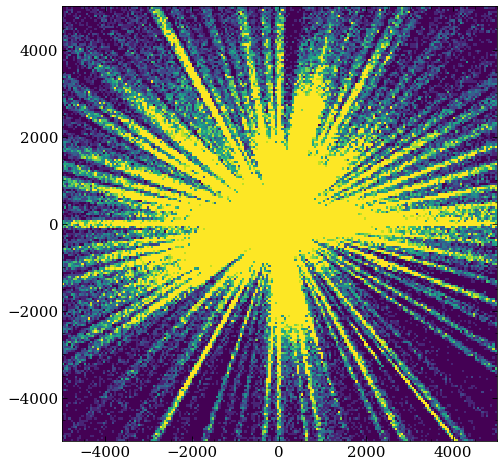

In [8]:
distance = 1000 / stars['GAIAEDR3_PARALLAX'] 
distance[distance < 0] = np.nan
star_coords = SkyCoord(l = stars['GLON'] * u.deg, b = stars['GLAT'] * u.deg, distance = distance*u.pc, frame = 'galactic')
star_coords.representation_type = 'cartesian'

fig, ax = plt.subplots(figsize = (8,8))
# ax.scatter(star_coords.u.value, star_coords.v.value)
norm = matplotlib.colors.Normalize(0, 10)


ax.hist2d(star_coords.u.value, star_coords.v.value, range = ((-5e3, 5e3), (-5e3, 5e3)), bins = 200, norm = norm)
ax.set_xlim(-5e3, 5e3)
ax.set_ylim(-5e3, 5e3)
# ax.scatter(star_coords.u.value[sel_galcen], star_coords.v.value[sel_galcen])
# ax.scatter(star_coords.u.value[sel_galfwd], star_coords.v.value[sel_galfwd])
ax.set_aspect('equal')
plt.show()

In [9]:
def continuum_shift(data):
    data_fit = np.copy(data[window_fit])
    offset = np.nanmedian(data_fit) - 1
    if np.abs(offset) < 0.02: 
        return offset
    else:
        return 0
    
def create_mask(bitmask, flags = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], skipflags = []):
    # https://www.sdss.org/dr14/algorithms/bitmasks/#APOGEE_PIXMASK
    if type(flags) is not list:
        flags = [flags]
    if type(skipflags) is not list:
        skipflags = [skipflags]

    mask = np.zeros(bitmask.shape)
    for i in flags:
        if i not in skipflags:
            mask[np.bitwise_and(bitmask, 2**i) == 2**i] = 1
    return mask


In [10]:
def calc_res(star):
 
    aspcap = fits.open(get_aspcap_path(row = star))
    apstar = fits.open(get_apstar_path(hdulist = aspcap))

    
    aspcap_spectrum = aspcap[1].data
    mask = create_mask(apstar[3].data[0, :], skipflags = [11])
    mask = mask + np.roll(mask, -1) + np.roll(mask, 1) + np.roll(mask, -2) + np.roll(mask, 2)
    aspcap_spectrum = np.ma.array(aspcap_spectrum, mask = mask)
    aspcap_spectrum = aspcap_spectrum.filled(np.nan)
    aspcap_model = aspcap[3].data
    res_rest = aspcap_spectrum / aspcap_model 
    medres = fits.open(get_medres(star['TEFF'], star['LOGG'], star['M_H']))
    res_corr = res_rest / medres[1].data

    # res_rest = res_rest 
    # res = resample_interp(res_rest, rv = star['VHELIO_AVG']).astype(float)
    res_corr = resample_interp(res_corr, rv = star['VHELIO_AVG']).astype(float)
    aspcap_spectrum = resample_interp(aspcap_spectrum, rv = star['VHELIO_AVG']).astype(float)
    aspcap_model = resample_interp(aspcap_model * medres[1].data, rv = star['VHELIO_AVG']).astype(float)



    return res_corr, aspcap_spectrum, aspcap_model


/tmp/ipykernel_1792623/2351256348.py:13: RuntimeWarning: invalid value encountered in true_divide
  res_rest = aspcap_spectrum / aspcap_model


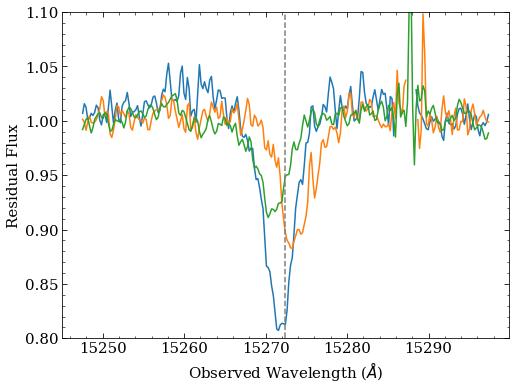

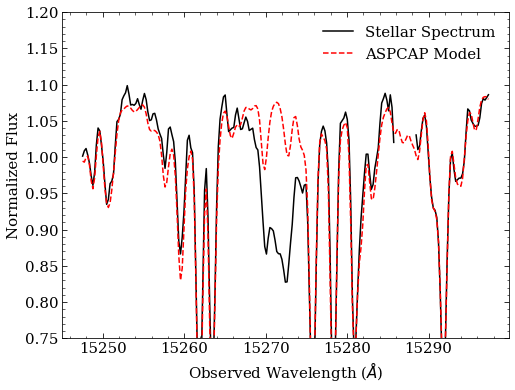

In [11]:
star_cen = stars[sel_galcen[2]]
star_fwd = stars[sel_galfwd[2]]
star_rev = stars[sel_galrev[0]]


res_cen, aspcap_cen, mod_cen = calc_res(star_cen)
res_fwd, aspcap_fwd, mod_fwd = calc_res(star_fwd)
res_rev, aspcap_rev, mod_rev = calc_res(star_rev)


fig, ax = plt.subplots(figsize = (8,6))

    
ax.plot(wavs_window, res_cen[window])
ax.plot(wavs_window, res_fwd[window])
ax.plot(wavs_window, res_rev[window])


ax.plot([lambda0, lambda0], [0.8, 1.1], color = 'grey', linestyle = 'dashed')

ax.set_ylim(0.8, 1.1)
ax.set_xlabel('Observed Wavelength ($\AA$)')
ax.set_ylabel('Residual Flux')
plt.savefig('../figures/DIB_galcen_galfwd.png')
plt.show()
## To do: clean up skylines, link to parts of the galaxy

fig, ax = plt.subplots(figsize = (8,6))

ax.plot(wavs_window, aspcap_cen[window], color = 'k', label = 'Stellar Spectrum')
ax.plot(wavs_window, mod_cen[window], color = 'r', linestyle = 'dashed', label = 'ASPCAP Model')
ax.set_xlabel('Observed Wavelength ($\AA$)')
ax.set_ylabel('Normalized Flux')
ax.set_ylim(0.75, 1.2)

ax.legend()
plt.savefig('../figures/spectrum_model.png')
plt.show()




In [12]:
### Dustmap coordinates
distance = np.linspace(0, 1000, 200)
offset = 20

l0, b0 = (161., -8.0)
l_ = np.linspace(l0 - offset, l0 + offset, 200)
b_ = np.linspace(b0 - offset, b0 + offset, 200)

# l, b, d = np.meshgrid(l_, b_, distance)
l_baye, b_baye = np.meshgrid(l_, b_)


# cacloud_coords = SkyCoord(l*u.deg, b*u.deg,
#                   distance=distance*u.pc, frame='galactic')

cacloud_coords_bayestar = SkyCoord(l_baye*u.deg, b_baye*u.deg,frame='galactic')

# A0Coeff = 1.052180128669157 # from 02-03dustmap_explore.ipynb, calculated via dustapprox

# vergelyquery = Vergely2022Query(map_fname = 
#                                 '/uufs/astro.utah.edu/common/home/u1371365/dustmaps_data/vergely2022/vergely22_extinction_density_resol_010pc.h5')
# vergely = vergelyquery(cacloud_coords) * A0Coeff

bayestarquery = BayestarQuery(map_fname = bayestar_path)
bayestar = bayestarquery(cacloud_coords_bayestar)


Loading pixel_info ...


Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 48.279 s
  pix_info:   0.876 s
   samples:  28.446 s
      best:   4.968 s
       nan:   0.028 s
      sort:  13.811 s
       idx:   0.151 s


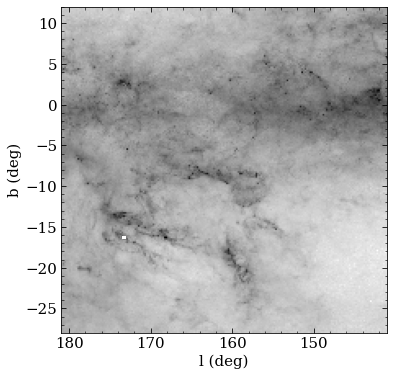

In [13]:
### Get Vergely+ (2022) dustmap for same points as Bayestar, now that it's in dustmaps


fig, ax = plt.subplots(figsize = (6,6))
# ax.imshow(np.sum(vergely * 5, axis = 2), origin = 'lower', cmap = 'binary', extent = (l0-offset, l0+offset, b0-offset, b0+offset))
ax.imshow(np.sqrt(bayestar[:,:, -1]), origin = 'lower', cmap = 'binary', extent = (l0-offset, l0+offset, b0-offset, b0+offset))

ax.set_xlim(l0+offset, l0-offset)
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
# ax.scatter(CA_meta['GLON'], CA_meta['GLAT'])
plt.savefig('../figures/CA_cloud_Bayestar.png')
plt.show()

In [14]:
### Dustmap coordinates
distance = np.linspace(0, 1000, 200)
offset = 8

lo0, bo0 = (211., -19.0)
lo_ = np.linspace(lo0 - offset, lo0 + offset, 200)
bo_ = np.linspace(bo0 - offset, bo0 + offset, 200)

lo_baye, bo_baye = np.meshgrid(lo_, bo_)
# print(l.shape)

ori_coords_bayestar = SkyCoord(lo_baye*u.deg, bo_baye*u.deg,frame='galactic')

A0Coeff = 1.052180128669157 # from 02-03dustmap_explore.ipynb, calculated via dustapprox


bayestar_ori = bayestarquery(ori_coords_bayestar)

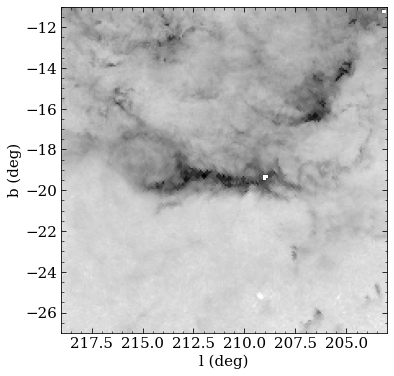

In [15]:
fig, ax = plt.subplots(figsize = (6,6))
# ax.imshow(np.sum(vergely * 5, axis = 2), origin = 'lower', cmap = 'binary', extent = (l0-offset, l0+offset, b0-offset, b0+offset))
ax.imshow(np.sqrt(bayestar_ori[:,:, -1]), origin = 'lower', cmap = 'binary', extent = (lo0-offset, lo0+offset, bo0-offset, bo0+offset))

ax.set_xlim(lo0+offset, lo0-offset)
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
# ax.scatter(CA_meta['GLON'], CA_meta['GLAT'])
plt.savefig('../figures/orion_cloud_Bayestar.png')
plt.show()

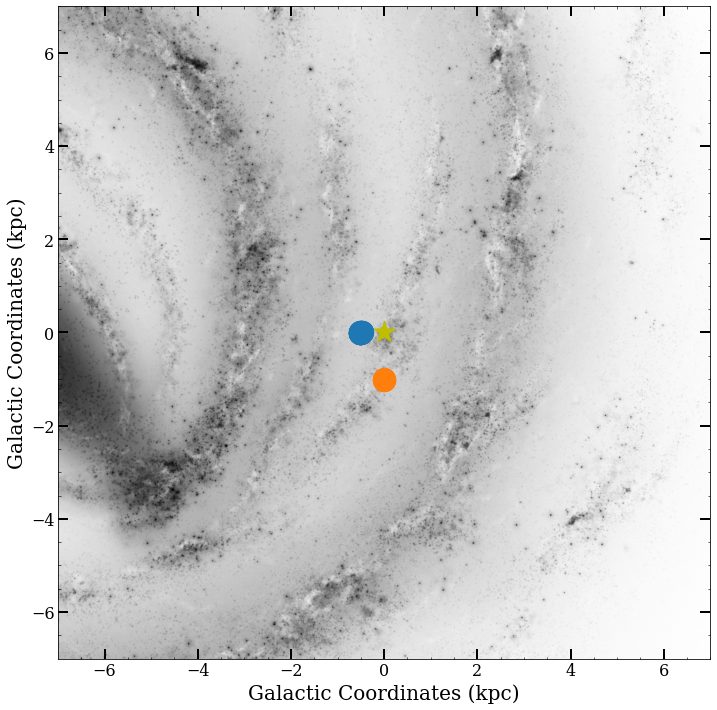

In [16]:
from mw_plot import MWPlot

mw1 = MWPlot(radius=7 * u.kpc, unit=u.kpc, coord='galactic', annotation=False, grayscale = True, rot90 = 0, figsize=(15, 12))
mw1.scatter(0 * u.kpc, 0 * u.kpc, marker = '*', c = 'y', s = 500)


# mw1.set_facecolor('white')

mw1.transform(ax)

mw1.scatter(-star_coords[sel_galcen].u, star_coords[sel_galcen].v, c = 'C0', s = 500)
mw1.scatter(-star_coords[sel_galfwd].u, star_coords[sel_galfwd].v, c = 'C1', s = 500)
plt.show()


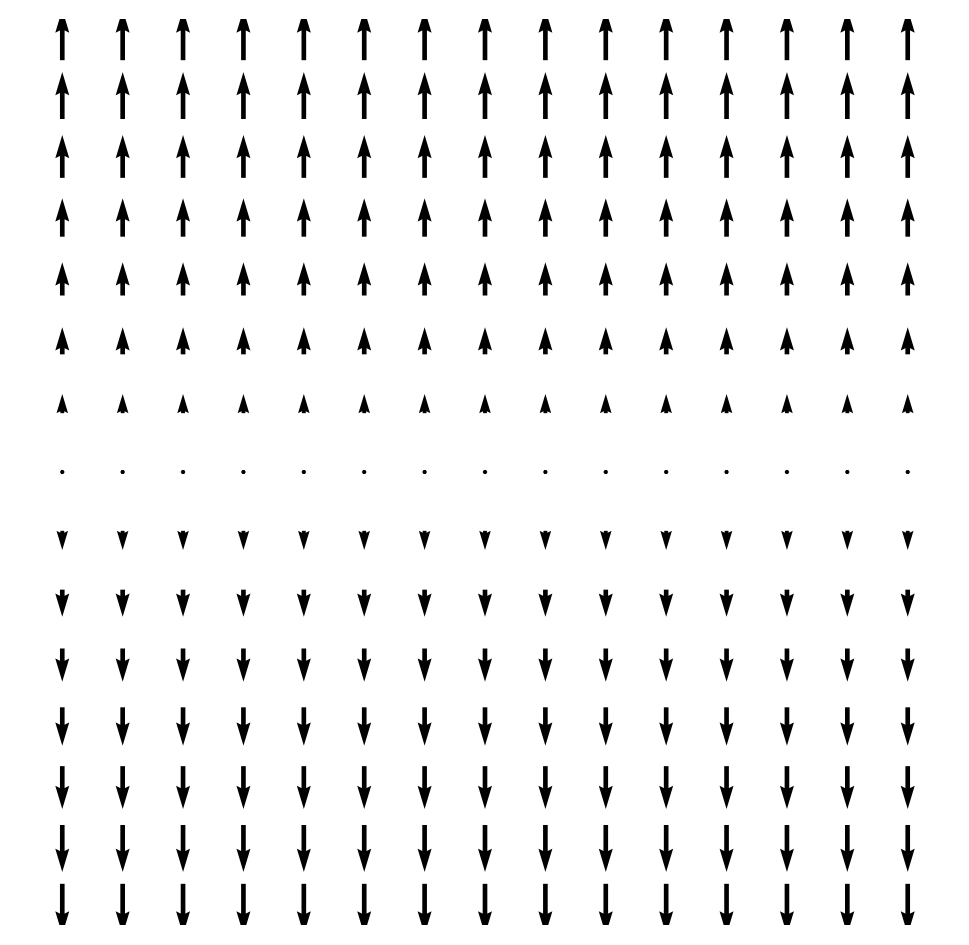

In [17]:
fig, ax = plt.subplots(figsize = (6, 6), dpi = 200)
xx, yy = np.meshgrid(np.linspace(-1, 1, 15), np.linspace(-1, 1, 15))
uu = 0
vv = yy
ax.quiver(xx, yy, uu, np.sign(vv) * np.abs(vv)**.5, width = 0.005)
# ax.set_aspect('equal')
fig.set_facecolor('white')
ax.axis('off')
# plt.savefig('../figures/quiver.png')
plt.show()

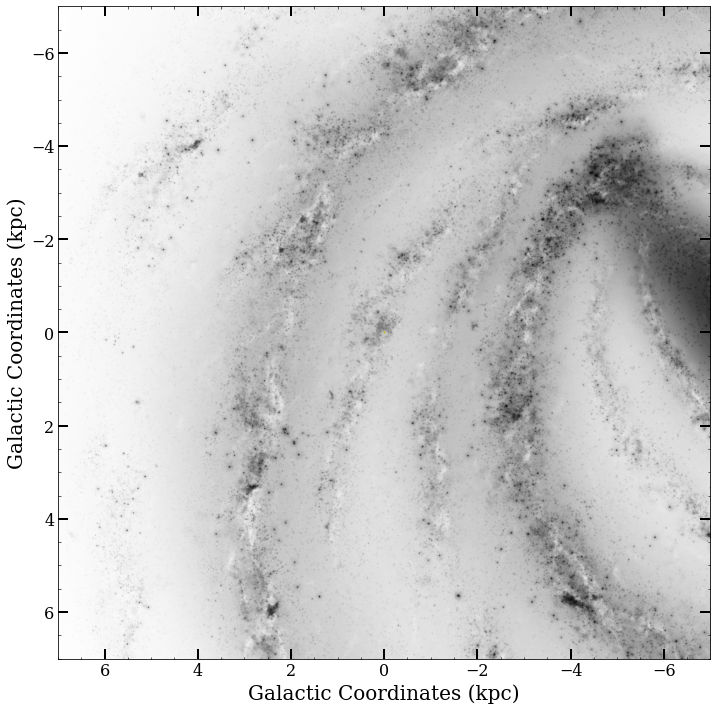

In [18]:

mw1 = MWPlot(radius=7 * u.kpc, unit=u.kpc, coord='galactic', annotation=False, grayscale = True, rot90 = 2, figsize=(15, 12))
mw1.scatter(0 * u.kpc, 0 * u.kpc, marker = '*', c = 'y', s = 1)


# mw1.set_facecolor('white')

mw1.transform(ax)

# mw1.scatter(-star_coords[sel_galcen].u, star_coords[sel_galcen].v, c = 'C0', s = 500)
# mw1.scatter(-star_coords[sel_galfwd].u, star_coords[sel_galfwd].v, c = 'C1', s = 500)
plt.show()

In [19]:
# sdss5 panoPtic-5